In [0]:
#ci permette di importare qualsiasi modulo
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/TensorFlow 2.0/modules')
import pandas as pd
import tf_dataset_extractor as e
#import grapher_v1_1 as g
#import LSTM_creator_v1_0 as l
v = e.v
g = e.g
l = e.l

In [0]:
v.upload.offline_csv()
e.K = v.upload.make_backup()

#Graph

In [0]:
import pandas as np
v.upload.retrieve_backup(e.K)
e.X.hist(figsize=(15, 15), grid=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(0.0, 0.0, 0.0)


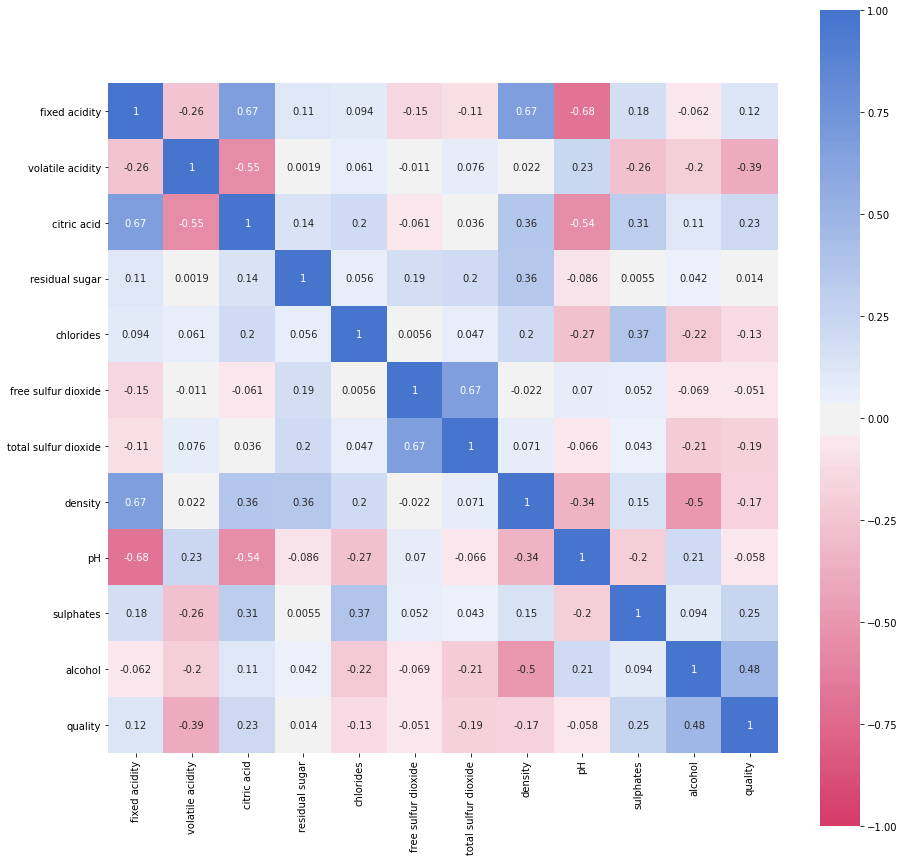

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
#a = sn.heatmap(e.X.corr(), annot=True)

corr = e.X.corr()

fig, ax = plt.subplots(figsize=(15,15)) 

# Generate a mask for the upper triangle
#mask = np.triu(np.ones_like(corr, dtype=np.bool))
#ax.set_facecolor((.21875, .21875, .21875))

print(matplotlib.colors.to_rgb('black'))

ax = sns.heatmap(
    corr,
    #mask=mask,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(0, 256, n=200),
    square=True,
    ax=ax,
    annot=True
)

In [0]:
v.upload.retrieve_backup(e.K)
#v.upload.remove(['quality'])
corr = e.X.corr()
df = pd.DataFrame(corr.values)
df = df.to_numpy()

df = df.reshape(144, )
df = pd.DataFrame(df)
df = df[df[0] != 1.0] 
df.hist(bins=20, figsize=(15,15), grid=False)

#Preprocessing

In [0]:
v.upload.retrieve_backup(e.K)
v.partition.label_encoder(['quality'], to_float=True)
#v.extract.labels(['quality'])
v.partition.one_hot(['quality'])
v.extract.labels(['quality_0.0', 'quality_1.0', 'quality_2.0', 'quality_3.0', 'quality_4.0', 'quality_5.0'])
e.y.head()

,quality_0.0,quality_1.0,quality_2.0,quality_3.0,quality_4.0,quality_5.0
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


In [0]:
#k = lambda x : x - 2
#v.partition.edit_continuous(['quality'], k)
scaler, e.X = v.partition.scale('all_df', scaler='MinMaxScaler', df=e.X, to_float=True, return_df=True)
#scaler, e.X = v.partition.scale('all_df', df=e.X, to_float=True, return_df=True)

e.X_numerical = e.X
e.X_categorical = pd.DataFrame()
X_train, X_test, y_train, y_test = v.cross_sectional_split(0.2, 14)
#scaler, X_train_norm = v.partition.scale(partitions='all_df', to_float=True, df=X_train, return_df=True)
#X_train.head()
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
837,0.185841,0.109589,0.28,0.102740,0.000000,0.492958,0.332155,0.041847,0.409449,0.035928,0.507692
1103,0.247788,0.253425,0.27,0.082192,0.098498,0.183099,0.067138,0.279732,0.480315,0.179641,0.553846
503,0.522124,0.095890,0.47,0.068493,0.110184,0.070423,0.063604,0.552864,0.346457,0.425150,0.384615
348,0.442478,0.301370,0.31,0.130137,0.128548,0.197183,0.141343,0.574890,0.291338,0.353293,0.246154
670,0.203540,0.191781,0.24,0.109589,0.118531,0.408451,0.137809,0.428040,0.409449,0.149701,0.246154


#Random Forest Classifier + Tuning

In [0]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(
  bootstrap=True,
  criterion='entropy',
  min_samples_split=3,
  n_estimators= 1400
  )

param_grid = {
    'n_estimators': [1, 2, 3], 
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 3, 4, 5],
    'bootstrap': [False, True]
}

v.tuning(clf, param_grid, X_train, y_train)
#clf = clf.fit(X_train, y_train)
#y_predict = clf.predict(X_test)
#from sklearn.metrics import accuracy_score
#print(accuracy_score(y_test, y_predict))

#X = pd.concat([X_train, X_test], axis=0)
#y = pd.concat([y_train, y_test], axis=0)
#v.cross_validation(clf, X, y, 10)

In [0]:
#predizione sul nostro split
clf = clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_predict))

In [0]:
#MOD
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
X.head()
cross_validation(clf, X, y, 10)
grid_search.best_params_
#y_predict = clf.predict(X_test)
from sklearn.metrics import accuracy_score
#print(accuracy_score(y_test, y_predict))

#MLP Classifier

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
print(tf.__version__)
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1
# instantiate regularizer
reg = l1(0.001)
model = Sequential()
model.add(Dense(250, activation='relu', kernel_initializer='he_normal', input_shape=(11, ), activity_regularizer=l1(0.002)))
model.add(BatchNormalization())
model.add(Dropout(0.8))
model.add(Dense(150, activation='relu', kernel_initializer='he_normal', activity_regularizer=l1(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(90, activation='relu', kernel_initializer='he_normal', activity_regularizer=l1(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
# compile the model
opt = SGD(lr=0.15, momentum=0.09)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=32, verbose=2)
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
!pip install keras-tuner


In [0]:
import kerastuner as kt
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    hyperband_iterations=2)

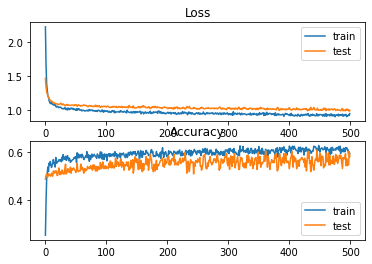

In [0]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()
# make a prediction
#row = [5.1,3.5,1.4,0.2]
#yhat = model.predict([row])
#print('Predicted: %s (class=%d)' % (yhat, np.argmax(yhat)))

In [0]:
from sklearn.datasets import make_regression
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
#generate regression dataset
a, b = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=1, n_targets=1)
# generate circles
a, b = make_circles(n_samples=1000, noise=0.1, random_state=1, factor=.9)
# generate dataset
a, b = make_blobs(n_samples=1000, centers=2, n_features=5, cluster_std=2, random_state=2)



a = pd.DataFrame(a)
b = pd.DataFrame(b)
b.head()


,0
0,0
1,0
2,1
3,1
4,0
